In [1]:
import numpy as np
import scipy.optimize
import scipy.interpolate
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import generate_steps, solve_disp
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import ceil
import os

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

# parameters

In [88]:
# aol = np.sqrt(2.65e-8)
aol = np.sqrt(1e-8)
print('aol = ', aol)
tc_tp = 2
th_tc = 6
nc_np = 0.95
nh_np = 1 - nc_np
# vc_va = 2.42
vc_va = 5
vh_va = -vc_va * nc_np / nh_np
print('vh_va = {0:.3g}'.format(vh_va))

# betap = 0.25
betap = .5
theta = 80


t_list=[1., tc_tp, th_tc * tc_tp]
a_list=[1., 1., 1.]
n_list=[1., nc_np, nh_np] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., vc_va, vh_va]
n = 6
method = 'pade'

k = 0.2

target_k = 2

kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol =  0.0001
vh_va = -95


In [154]:
class KThetaScan:
    """
    Scan a wave mode in wavenumber (k) vector. 
    k vector is parametrized by magnitude k and angle theta w.r.t. mean magnetic field.
    """
    def __init__(self, param,
                 guessFn = None, 
                 incrmt_method = 'linear', 
                 lin_incrmt = 0.05, 
                 log_incrmt = 0.05, 
                 stop_condition = None,
                 diagnostic_dir = '.', 
                 savefig = False):
        """
        Constructor
        
        param: a list containing 
            [kz, kp, betap, t_list, a_list, n_list, q_list, m_list, v_list, n, method, aol]
        """
        self.param = param
        if guessFn:
            self.guessFn = guessFn
        else:
            print("No user provided wave mode guess function. Use default Alfven guess.")
            self.guessFn = self.AlfvenGuess
        self.incrmt_method = incrmt_method
        self.lin_incrmt = lin_incrmt
        self.log_incrmt = log_incrmt
        self.stop_condition = stop_condition
        self.maxGrowthRate = None
        self.maxGrowthK = None
        self.savefig = savefig
        try: 
            self.diagnostic_dir = os.path.abspath(diagnostic_dir)
        except Exception:
            print("Do not recognize directory {0}".format(diagnostic_dir))
            print("Use current directory instead {0}".format(os.path.curdir))
            self.diagnostic_dir = os.path.abspath(os.path.curdir)
    
    def getParamString(self):
        return self.getElectronDriftParamString()
    
    def getElectronDriftParamString(self):
        t_list = self.param[3]
        n_list = self.param[4]
        v_list = self.param[8]
        aol = self.param[11]
        tctp = t_list[1]/t_list[0]
        thtc = t_list[2]/t_list[1]
        vcva = v_list[1]
        va2c2 = aol
        annot = "$T_c/T_p = ${0:.2g}".format(tctp) + "\n"
        annot += "$T_h/T_c = ${0:.2g}".format(thtc) + "\n"
        annot += "$v_c/v_A = ${0:.3g}".format(vcva) + "\n"
        annot += "$v_A/c = ${0:.2g}".format(aol)
        
        title = "tctp={0:.2g}_thtc={1:.2g}_vcva={2:.3g}_vac={3:.2g}".format(tctp, thtc, vcva, aol)
        return annot, title
        
    def guess(self, kz, kp):
        return self.guessFn(kz, kp)
       
    def AlfvenGuess(self, kz, kp):
        betap = self.param[2]
        return kz / np.sqrt(betap)
 
    def follow_k(self, seed_freq, target_value, param, pol='r', show_plot=False,
                 log_incrmt=0.1, lin_incrmt=0.1, incrmt_method = 'log', stop_condition = None):
        """
        follow mode along wavenumber parameter.
        """    
        (kz, kp, beta, t_list, a_list, n_list, q_list, m_list,
         v_list, n, method, aol) = param
        seed_k = np.sqrt(kz**2 + kp**2)
        kz_k = kz/seed_k
        kp_k = kp/seed_k
        # a list of k to step through
        k_list = generate_steps(seed_k, target_value, log_incrmt=log_incrmt,
                                lin_incrmt=lin_incrmt, incrmt_method = incrmt_method)
        freq_lst = []
        guess = seed_freq
        for k in k_list:
            kz, kp = k * kz_k, k * kp_k
            guess = solve_disp(guess, kz, kp, beta, t_list, a_list,
                               n_list, q_list, m_list, v_list,
                               n, method, aol, pol)
            if stop_condition and stop_condition(guess):
                break
            freq_lst.append(guess)
        return freq_lst

    def fixThetaScan(self, theta, kmin, kmax):
        kz, kp = kzkp(kmin, theta)
        guess = self.guess(kz, kp)
        self.param[0] = kz
        self.param[1] = kp


        freq = self.follow_k(guess, kmax, param,
                        lin_incrmt = self.lin_incrmt, 
                        log_incrmt = self.log_incrmt, 
                        incrmt_method = self.incrmt_method,
                        stop_condition = self.stop_condition)  
        k_arr = generate_steps(kmin, kmax, log_incrmt=self.log_incrmt,
                             lin_incrmt=self.lin_incrmt, incrmt_method = self.incrmt_method)
        kz_arr = k_arr * np.cos(np.deg2rad(theta))
        kp_arr = k_arr * np.sin(np.deg2rad(theta))
        wrel_arr = np.array(freq)
        return kz_arr, kp_arr, k_arr, wrel_arr
    
    def fullScan(self, theta_arr, kmin, kmax):
        k_arr = generate_steps(kmin, kmax, log_incrmt=self.log_incrmt,
                             lin_incrmt=self.lin_incrmt, incrmt_method = self.incrmt_method)
        kz_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
        kp_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
        k_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = float)
        wrel_2d = np.zeros((len(theta_arr), len(k_arr)), dtype = complex)
        wrel_2d.fill(np.nan + 1j * np.nan)
        
        for i, theta in enumerate(theta_arr):
            kz_arr, kp_arr, k_arr, wrel_arr = self.fixThetaScan(theta, kmin, kmax)
            kz_2d[i, :] = kz_arr
            kp_2d[i, :] = kp_arr
            k_2d[i, :] = k_arr
            wrel_2d[i, :len(wrel_arr)] = wrel_arr        
        return kz_2d, kp_2d, k_2d, wrel_2d 

    def edges2grid(self, edges):
        """
        convert edges of histogram bins (from numpy.hist2d output) 
        to grid (center of the bins)
        """
        grid = (np.roll(edges, 1) + edges)/2
        return grid[1:]

    def makeDiagnostics2D(self, theta_arr, kz_2d, kp_2d, wrel_2d):
        mask = ~np.isnan(wrel_2d) & (wrel_2d.real > 0)
        
        xmin, xmax = np.min(kz_2d[mask]), np.max(kz_2d[mask])
        ymin, ymax = np.min(kp_2d[mask]), np.max(kp_2d[mask])

        x_edges, y_edges = np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100)
        x_grid, y_grid = self.edges2grid(x_edges), self.edges2grid(y_edges)
        x_i, y_i = np.meshgrid(x_grid, y_grid)
        x_2d = kz_2d
        y_2d = kp_2d
        z_2d = wrel_2d.real
        
        mask = ~np.isnan(wrel_2d) & (wrel_2d.imag > 0)
        wrel_real_i = scipy.interpolate.griddata((x_2d[mask].flatten(), y_2d[mask].flatten()), 
                                                 wrel_2d[mask].real.flatten(), (x_i, y_i), 
                                                 method='linear')

        wrel_imag_i = scipy.interpolate.griddata((x_2d[mask].flatten(), y_2d[mask].flatten()), 
                                                 wrel_2d[mask].imag.flatten(), (x_i, y_i), 
                                                 method='cubic')
        
        self.maxGrowthRate = np.max(wrel_imag_i[~np.isnan(wrel_imag_i)])
        pos = np.where(wrel_imag_i == self.maxGrowthRate)
        max_x = x_i[pos]
        max_y = y_i[pos]
        self.maxGrowthK = [max_x, max_y]
    
        z = np.ma.masked_where(np.isnan(wrel_real_i), wrel_real_i)
        plt.pcolormesh(x_edges, y_edges, 
                       z, vmin=1e-2, vmax=np.max(z), cmap = plt.cm.jet)
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        plt.plot([max_x], [max_y], 'k+')
        plt.xlabel(r'$k_\parallel\rho_p$')
        plt.ylabel(r'$k_\perp \rho_p$')
        plt.title(r'$\omega_r/\Omega_p$')
        plt.colorbar()
        plt.show()
        
        if self.maxGrowthRate < 1e-6:
            return 
        z = np.ma.masked_where(np.isnan(wrel_imag_i), wrel_imag_i)
        vmax = np.max(z)
        vmin = np.max([1e-5, vmax/500])
        pcm = plt.pcolormesh(x_edges, y_edges, z, 
                             vmin=vmin, vmax=vmax, cmap = plt.cm.jet, 
                             norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        # we only make two contour lines
        max_contour = np.floor(np.log(self.maxGrowthRate))
        contour_vals = [10**(max_contour-1), 10**max_contour]
        CS = plt.contour(x_grid, y_grid, z, contour_vals, colors = 'k')
        plt.clabel(CS, inline=1, fontsize=10, fmt='%.2g')
        plt.xlim([0, np.max(kz_2d)])
        plt.ylim([0, np.max(kp_2d)])
        plt.plot(max_x, max_y, 'k+')
        plt.plot([0, 1], [0, 1], 'k')
        plt.xlabel(r'$k_\parallel\rho_p$')
        plt.ylabel(r'$k_\perp \rho_p$')
        plt.title(r'$\omega_i/\Omega_p$')
        plt.axvline(0, color = 'k')
        plt.colorbar(pcm)
        plt.tight_layout()
        # plt.savefig('figure/gary_1975_fig4_reproduced.png', dpi = 200)
        plt.show()
        
        
    def makeDiagnostics1D(self, theta_arr, k_2d, wrel_2d):
        """
        Produce diagnostics plots:
            1, real freq vs wave number.
            2, imaginary freq vs wave number.
        """
        # at most label 5 curves
        n = ceil(len(theta_arr)/5)
        for i, wrel_arr in enumerate(wrel_2d):
            if i % n == 0:
                plt.plot(k_2d[i, :], wrel_arr.real, label = '{0:.3g}'.format(theta_arr[i]))
            else:
                plt.plot(k_2d[i, :], wrel_arr.real)
        not_nan = ~np.isnan(wrel_arr)
        wrel_real_pos = 0.2 * np.max(wrel_arr[not_nan].real) + 0.8 * np.min(wrel_arr[not_nan].real)
        wrel_imag_pos = 0.8 * np.max(wrel_arr[not_nan].imag) + 0.2* np.min(wrel_arr[not_nan].imag)
        k_real_pos = 0.3 * k_2d[0, 0] + 0.7 * k_2d[0, -1]
        k_imag_pos = 0.8 * k_2d[0, 0] + 0.2 * k_2d[0, -1]
        annot, title = self.getParamString()
        print(title)
        plt.xlabel(r'$k\rho_p$')
        plt.ylabel(r'$\omega_r/\Omega_p$')
        plt.legend(fontsize = 10, frameon=False)
        plt.text(k_real_pos, wrel_real_pos, annot)
        plt.tight_layout()
        fileName = os.path.join(self.diagnostic_dir, title + '_real_freq.png')
        if self.savefig:
            plt.savefig(fileName, dpi = 100)
        plt.show()
        
        for i, wrel_arr in enumerate(wrel_2d):
            if i % n == 0:
                plt.plot(k_2d[i, :], wrel_arr.imag, label = '{0:.3g}'.format(theta_arr[i]))
            else:
                plt.plot(k_2d[i, :], wrel_arr.imag)
        plt.xlabel(r'$k\rho_p$')
        plt.ylabel(r'$\omega_i/\Omega_p$')
        mask = ~np.isnan(wrel_2d)
        gamma_max = np.max(wrel_2d[mask].imag)
        if gamma_max > 0:
            plt.ylim([-1e-3, 2 * gamma_max])
        plt.legend(fontsize = 10, frameon=False)
        plt.text(k_imag_pos, wrel_imag_pos, annot)
        plt.tight_layout()
        fileName = os.path.join(self.diagnostic_dir, title + '_imag_freq.png')
        if self.savefig:
            plt.savefig(fileName, dpi = 100) 
        plt.show()

In [155]:
alfven_stop_condition = lambda wrel: (wrel.real > 1) or (wrel.imag < -1.)

# ktscan = KThetaScan(param, 
#                     log_incrmt=.05, 
#                     incrmt_method='log', 
#                     stop_condition=alfven_stop_condition)
# ktscan = KThetaScan(param, 
#                     lin_incrmt=.02, 
#                     incrmt_method='linear', 
#                     stop_condition=alfven_stop_condition)
ktscan = KThetaScan(param, 
                    lin_incrmt=.05, 
                    incrmt_method='linear', stop_condition=alfven_stop_condition)
theta_arr = np.linspace(80, 89.5, 19)
# theta_arr = np.linspace(75, 80, 5)

No user provided wave mode guess function. Use default Alfven guess.


# Check against dshark high frequency alfven waves

$\Omega_{ci}/\omega_{pi} = \frac{eB}{m_i} \sqrt{\frac{\epsilon_0 m_i}{ne^2}} = v_A/c$

In [134]:
# kz_arr, kp_arr, k_arr, wrel_arr = ktscan.fixThetaScan(74, 0.1, 3.)

In [135]:
# dshark_disp = np.loadtxt('/Users/Tong/Google_Drive/research/packages/DSHARK/DSHARK_gfortran/omega.dat')
# k_arr_ds = dshark_disp[:, 0]
# wrel_arr_ds =  dshark_disp[:, 1] + 1j * dshark_disp[:, 2]

In [136]:
class DRVisualizer:
    def __init__(self):
        self.k_arrs = []
        self.wrel_arrs = []
        self.label_arr = []
        self.marker_arr = []
        self.if_label = False
        self.fig = None
        self.axes = None
        
    def addDR(self, k_arr, wrel_arr, label=None, marker=None):
        assert len(k_arr) == len(wrel_arr)
        self.k_arrs.append(k_arr)
        self.wrel_arrs.append(wrel_arr)
        line_label = label if label else None
        self.label_arr.append(line_label)
        self.if_label |= True if label else False
        self.marker_arr.append(marker if marker else None)
        
    def setupAxes(self, xlabel=r'$k\rho_p$',
                  ylabel_1 = r'$\omega_r/\Omega_p$', 
                  ylabel_2 = r'$\omega_i/\Omega_p$', 
                  sharex = True, figsize = [5, 6],
                  **kwargs):
        fig, axes = plt.subplots(2, 1, sharex = sharex, 
                                 figsize = figsize, **kwargs)
        i = 0
        axes[i].set_ylabel(ylabel_1)
        i = 1
        axes[i].set_ylabel(ylabel_2)
        axes[i].set_xlabel(xlabel)
        self.fig = fig
        self.axes = axes
        
    def plotDR(self):
        for i in range(len(self.k_arrs)):
            self.axes[0].plot(self.k_arrs[i], self.wrel_arrs[i].real, 
                              label = self.label_arr[i], marker = self.marker_arr[i])            
            self.axes[1].plot(self.k_arrs[i], self.wrel_arrs[i].imag, 
                              label = self.label_arr[i], marker = self.marker_arr[i])
        if self.if_label:
            self.axes[0].legend(loc='best', frameon=False)           

In [137]:
# drv = DRVisualizer()
# drv.addDR(k_arr, wrel_arr, label = 'Tong', marker = '+')
# drv.addDR(k_arr_ds, wrel_arr_ds, label = 'DSHARK')

In [138]:
# drv.setupAxes()
# drv.plotDR()
# info_txt = r'$\beta_p={0:.2g}$'.format(betap) + "\n"
# info_txt += r'$T_i = T_e$' + "\n"
# info_txt += r'$\theta_{kB} = 74^\circ$' + "\n"
# info_txt += r'$v_A/c=10^{-4}$'
# drv.axes[0].plot(k_arr, kz_arr, '--', label = r'$k_\parallel v_A$')
# drv.axes[1].text(.5, -.4, info_txt, fontsize = 16)
# drv.axes[0].legend(frameon=False)
# plt.tight_layout()
# # drv.fig.savefig('figure/non_cyclotron_resonant_alfven_wave.png', dpi=200)
# plt.show()

In [156]:
kz_2d, kp_2d, k_2d, wrel_2d = ktscan.fullScan(theta_arr, 0.2, 5)

tctp=2_thtc=6_vcva=5_vac=0.0001


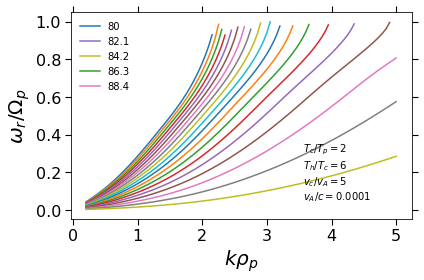

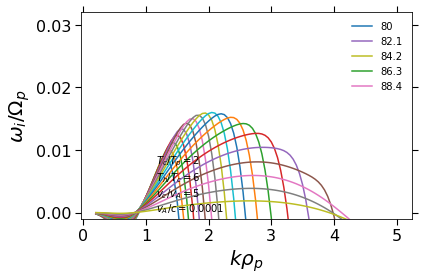

In [157]:
ktscan.makeDiagnostics1D(theta_arr, k_2d, wrel_2d)

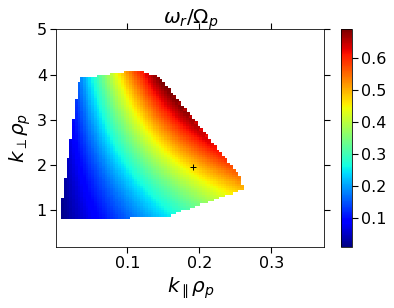

/Users/Tong/Envs/science/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


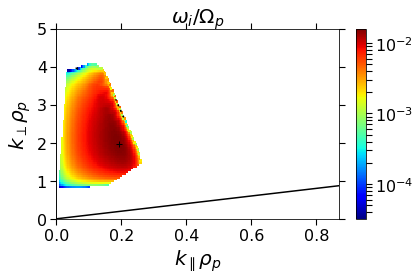

In [158]:
ktscan.makeDiagnostics2D(theta_arr, kz_2d, kp_2d, wrel_2d)

In [109]:
ktscan.maxGrowthRate

0.01605612364284479

In [163]:
np.rad2deg(np.arctan(ktscan.maxGrowthK[1]/ktscan.maxGrowthK[0]))

array([ 84.44723195])